# TMVA Reader

In this tutorial we use the TMVA::Reader to apply our MVA discriminants to our dataset, or any new dataset (with the same input variables). This is the kind of code one uses to deploy the algorithm.

We start by intializing the session as necessary.

In [1]:
# Importing the ROOT module
import ROOT
# Importing TMVA
from ROOT import TMVA

# Specifying the Keras backend
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Initialising TMVA
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize()



Welcome to JupyROOT 6.18/04


We open the input file and confirm that the signal and background trees are present (using `TFile::ls()`).

In [2]:
inputFile = ROOT.TFile("Higgs_data.root")
inputFile.ls()

TFile**		Higgs_data.root	
 TFile*		Higgs_data.root	
  KEY: TTree	sig_tree;1	Signal Tree
  KEY: TTree	bkg_tree;1	Background Tree


We now define local arrays to host the intput values and map them to the branches of the trees. Note that at this stage we don't need yet to provide the trees: this will be done later.

In [3]:
reader = TMVA.Reader( "!Color:!Silent" )

# Defining the arrays that will store the input data
# Note: using C++ class member variable naming convention
from array import array
m_jj = array('f',[0])
m_jjj = array('f',[0])
m_lv = array('f',[0])
m_jlv = array('f',[0])
m_bb = array('f',[0])
m_wbb = array('f',[0])
m_wwbb = array('f',[0])

reader.AddVariable("m_jj",m_jj)
reader.AddVariable("m_jjj",m_jjj)
reader.AddVariable("m_lv",m_lv)
reader.AddVariable("m_jlv",m_jlv)
reader.AddVariable("m_bb",m_bb)
reader.AddVariable("m_wbb",m_wbb)
reader.AddVariable("m_wwbb",m_wwbb)

We now load the various models we trained into the reader. The model parameters are stored at the following location: `dataset/weights/FactoryName_Algorithm.weights.xml`, where `dataset` is the name we previously gave to the loader.

In [4]:
# Using the name of the factory created when training the algorithms
factoryName = "TMVAClassHiggsMVAComp"
methodNames = [ "BDT", "PyGTB", "PyRandomForest", "PyAdaBoost", "MLP", "DL_CPU", "Keras_Dense"]
for methodName in methodNames:
    weightsFile = "dataset/weights/" + factoryName + "_" + methodName + ".weights.xml"
    name = ROOT.TString( methodName )
    reader.BookMVA( name, weightsFile )

Using TensorFlow backend.


                         : Booking "BDT" of type "BDT" from dataset/weights/TMVAClassHiggsMVAComp_BDT.weights.xml.
                         : Reading weight file: dataset/weights/TMVAClassHiggsMVAComp_BDT.weights.xml
<HEADER> DataSetInfo              : [Default] : Added class "Signal"
<HEADER> DataSetInfo              : [Default] : Added class "Background"
                         : Booked classifier "BDT" of type: "BDT"
                         : Booking "PyGTB" of type "PyGTB" from dataset/weights/TMVAClassHiggsMVAComp_PyGTB.weights.xml.
                         : Reading weight file: dataset/weights/TMVAClassHiggsMVAComp_PyGTB.weights.xml
                         : Booked classifier "PyGTB" of type: "PyGTB"
                         : Booking "PyRandomForest" of type "PyRandomForest" from dataset/weights/TMVAClassHiggsMVAComp_PyRandomForest.weights.xml.
                         : Reading weight file: dataset/weights/TMVAClassHiggsMVAComp_PyRandomForest.weights.xml
                   

Next we need to crate the histograms (or any other container) to hold the output of the classifiers for each event from the signal and background samples. We †create two dictionaties: one for signal and one for background. Each dictionary will have a key corresponding to each algorithm stored in `methodNames`. The output of our classifiers will be between -1 and 1 (some even between 0 and 1).

In [5]:
sigHist = {}
bkgHist = {}
for name in methodNames:
    hName = "hSig_" + name
    hTitle = "Classifier Output for " + name 
    sigHist[name] = ( ROOT.TH1F(hName,hTitle+" (Sig)",100,-1,1) )
    hName = "hBkg_" + name
    bkgHist[name] = (ROOT.TH1F(hName,hTitle+" (Bkg)",100,-1,1) )


We are now ready to process the input data and run it trough the reader. We start by allocating an array consisting in a vector of size equal to the number of events for each classifier. Then, we loop over the events in the TTree, saving the values of the branches in the predefined variables and computing the classifier output with `TMVA::Reader::EvaluateMVA()`.

In [6]:
import numpy as np

# Getting the number of events in the TTree (to set the size of the output array)
nEvnt = inputFile.bkg_tree.GetEntries()

# The output array: one vector of size nEvnt for each classifier
vOut = np.arange( nEvnt * len(methodNames), dtype='float').reshape( len(methodNames), nEvnt)

# We loop over each event in the TTree
for iEvnt,entry in enumerate(inputFile.bkg_tree):
    m_jj[0] = entry.m_jj
    m_jjj[0] = entry.m_jjj
    m_lv[0] = entry.m_lv
    m_jlv[0] = entry.m_jlv
    m_bb[0] = entry.m_bb
    m_wbb[0] = entry.m_wbb
    m_wwbb[0] = entry.m_wwbb
    
    # We loop over each event 
    for i,methodName in enumerate(methodNames): 
        vOut[i,iEvnt] = reader.EvaluateMVA(methodName)
        bkgHist[methodName].Fill(vOut[i,iEvnt])        
        if (iEvnt%1000)==0 : print 'Event ',iEvnt,' MVA output for ',methodName,' =',vOut[i,iEvnt]
    
    # Uncomment the line below in case you dont' have time to run over the whole sample   
    # if (iEvnt > 4000) : break
vOutBkg = vOut

Event  0  MVA output for  BDT  = 0.19927385556409993
Event  0  MVA output for  PyGTB  = 0.6074429328785591
Event  0  MVA output for  PyRandomForest  = 0.7162087875021541
Event  0  MVA output for  PyAdaBoost  = 0.5006362224411278
Event  0  MVA output for  MLP  = 0.7395838234286972
Event  0  MVA output for  DL_CPU  = 0.7096924781799316
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Event  0  MVA output for  Keras_Dense  = 0.5516724586486816
Event  1000  MVA output for  BDT  = -0.3440679084772371
Event  1000  MVA output for  PyGTB  = 0.11704508710132067
Event  1000  MVA output for  PyRandomForest  = 0.2928525377236729
Event  1000  MVA output for  PyAdaBoost  = 0.49894740297946
Event  1000  MVA output for  MLP  = 0.42937884804244963
Event  1000  MVA output for  DL_CPU  = 0.22293171286582947
Event  1000  MVA output for  Keras_Dense  = 0.21789811551570892
Event  2000  MVA output for  BDT  = -0.039046703064971475
Event  2000  MVA output for  PyGTB  = 0.47668

2020-01-29 23:09:49.481650: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-01-29 23:09:49.526155: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9c70e6f660 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-01-29 23:09:49.526179: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [7]:
# Getting the number of events in the TTree (to set the size of the output array)
nEvnt = inputFile.sig_tree.GetEntries()

# The output array: one vector of size nEvnt for each classifier
vOut = np.arange( nEvnt * len(methodNames), dtype='float').reshape( len(methodNames), nEvnt)

# We loop over each event in the TTree
for iEvnt,entry in enumerate(inputFile.sig_tree):
    m_jj[0] = entry.m_jj
    m_jjj[0] = entry.m_jjj
    m_lv[0] = entry.m_lv
    m_jlv[0] = entry.m_jlv
    m_bb[0] = entry.m_bb
    m_wbb[0] = entry.m_wbb
    m_wwbb[0] = entry.m_wwbb
    
    # We loop over each event 
    for i,methodName in enumerate(methodNames): 
        vOut[i,iEvnt] = reader.EvaluateMVA(methodName)
        sigHist[methodName].Fill(vOut[i,iEvnt])        
        if (iEvnt%1000)==0 : print 'Event ',iEvnt,' MVA output for ',methodName,' =',vOut[i,iEvnt]
    
    # Uncomment the line below in case you dont' have time to run over the whole sample   
    # if (iEvnt > 4000) : break
vOutSig = vOut

Event  0  MVA output for  BDT  = 0.20962112528706492
Event  0  MVA output for  PyGTB  = 0.6766202906131731
Event  0  MVA output for  PyRandomForest  = 0.5789558007461448
Event  0  MVA output for  PyAdaBoost  = 0.5004635686687161
Event  0  MVA output for  MLP  = 0.7276959432638143
Event  0  MVA output for  DL_CPU  = 0.7150067090988159
Event  0  MVA output for  Keras_Dense  = 0.7506874799728394
Event  1000  MVA output for  BDT  = 0.27890022856869445
Event  1000  MVA output for  PyGTB  = 0.8314158436170255
Event  1000  MVA output for  PyRandomForest  = 0.7121180182044661
Event  1000  MVA output for  PyAdaBoost  = 0.5008877844334116
Event  1000  MVA output for  MLP  = 0.8173728636599795
Event  1000  MVA output for  DL_CPU  = 0.8778777718544006
Event  1000  MVA output for  Keras_Dense  = 0.8713151812553406
Event  2000  MVA output for  BDT  = -0.08671196721232904
Event  2000  MVA output for  PyGTB  = 0.4208208810234142
Event  2000  MVA output for  PyRandomForest  = 0.4297372821987647
Event  

We now proceed with the plotting of the discriminant outputs, to check how our algorithms perform.

Info in <TCanvas::Print>: pdf file ./Discriminant Output.pdf has been created


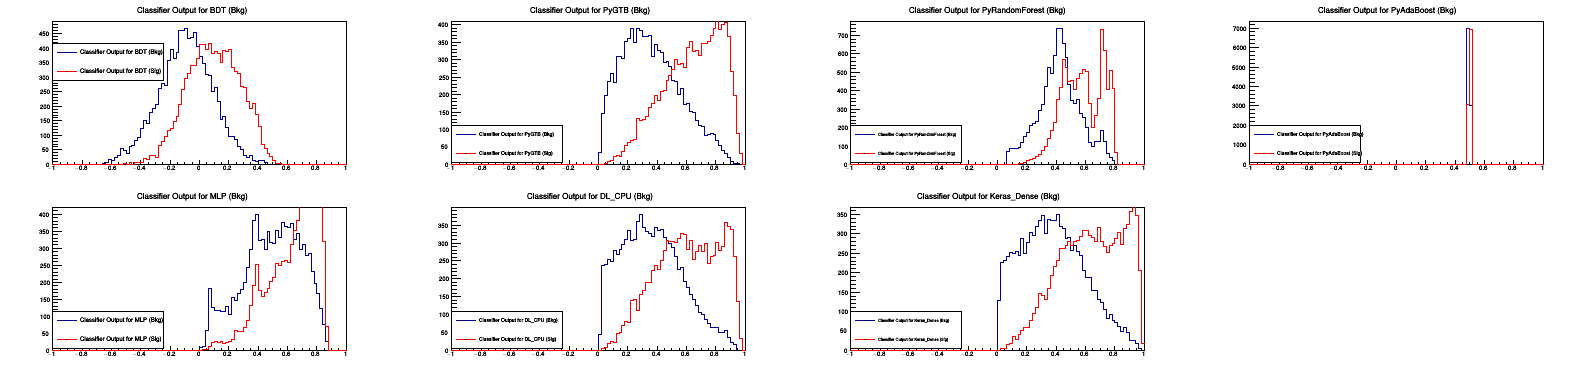

In [8]:
cOut = ROOT.TCanvas("Discriminant Output", "", 1600, 400)
cOut.DivideSquare( len(methodNames) )
ROOT.gStyle.SetOptStat(0)
for i,name in enumerate(methodNames):
    pad = cOut.cd(i+1)
    bkgHist[name].Draw()
    sigHist[name].SetLineColor(ROOT.kRed)
    sigHist[name].Draw("same")
    pad.BuildLegend()
    
cOut.Draw()
cOut.Print(".pdf")